In [12]:
# Data handling
import pandas as pd
import numpy as np
import os

# Image handling
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Check environment
print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Path to dataset
data_path = "/Users/pranavvaddepalli/plant_pathology_2021"

# Check contents of the folder
print("Files in dataset:", os.listdir(data_path))

# Load the training CSV
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
print("Training data sample:")
print(train_df.head())

Files in dataset: ['test_images', 'train.csv', 'train_images', 'sample_submission.csv']
Training data sample:
                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2  80070f7fb5e2ccaa.jpg                             scab
3  80077517781fb94f.jpg                             scab
4  800cbf0ff87721f8.jpg                          complex


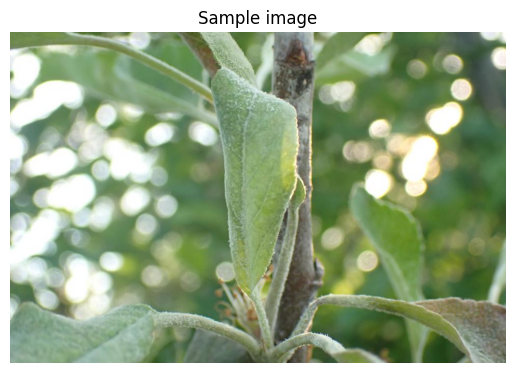

In [14]:
# Pick a random image from the training set
sample_img = train_df.sample(1).iloc[0]["image"]  # Random image name
img_path = os.path.join(data_path, "train_images", sample_img)

# Open and show the image
img = Image.open(img_path)
plt.imshow(img)
plt.title("Sample image")
plt.axis("off")
plt.show()

In [15]:
# Dataset stats
num_samples = len(train_df)
unique_labels = train_df['labels'].unique()
label_counts = train_df['labels'].value_counts()

print(f"Number of training samples: {num_samples}\n")
print(f"Unique labels ({len(unique_labels)}): {unique_labels}\n")
print("Label counts:")
print(label_counts)

Number of training samples: 18632

Unique labels (12): ['healthy' 'scab frog_eye_leaf_spot complex' 'scab' 'complex'
 'cider_apple_rust' 'frog_eye_leaf_spot' 'powdery_mildew'
 'scab frog_eye_leaf_spot' 'frog_eye_leaf_spot complex'
 'rust frog_eye_leaf_spot' 'powdery_mildew complex' 'rust complex']

Label counts:
labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
cider_apple_rust                   1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64


/var/folders/9r/wzgfdg_j65q_jspfls970n740000gn/T/ipykernel_12174/62507267.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


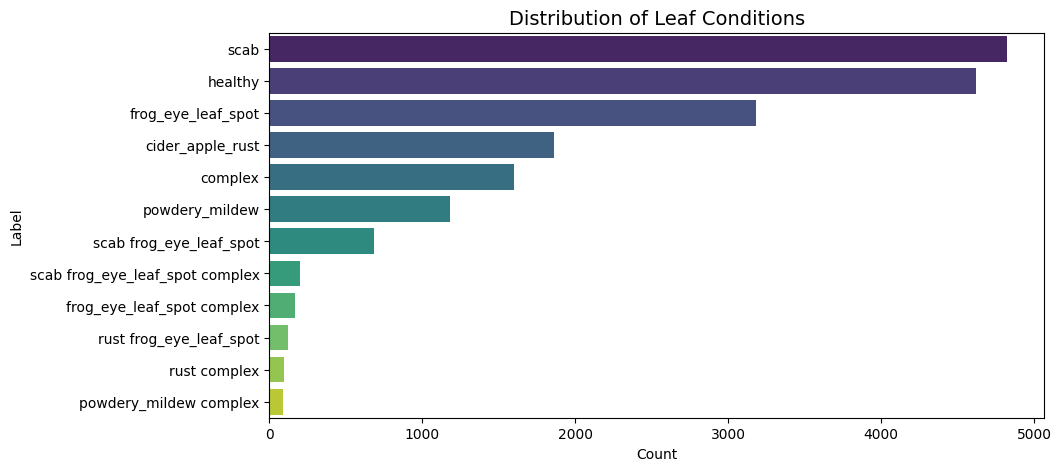

In [16]:
# Plot label distribution
plt.figure(figsize=(10, 5))
sns.countplot(
    y="labels",
    data=train_df,
    order=label_counts.index,
    palette="viridis"
)
plt.title("Distribution of Leaf Conditions", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Label")
plt.show()

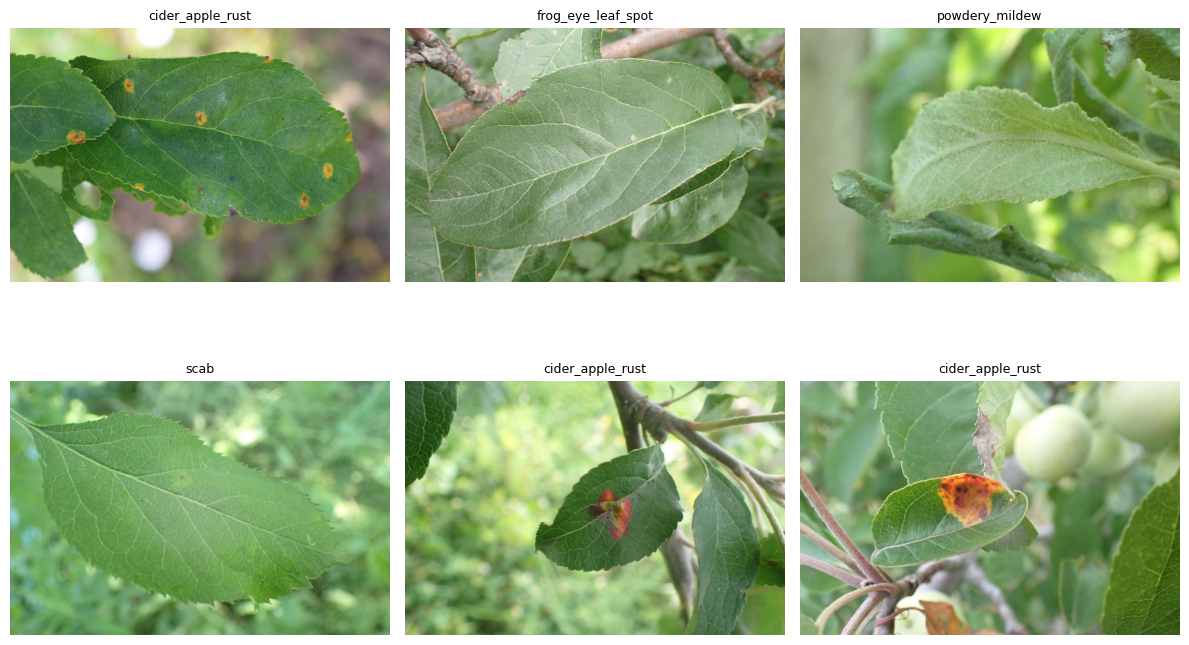

In [17]:
def show_samples(df, n=6):
    plt.figure(figsize=(12, 8))
    sample = df.sample(n)
    for i, (img_name, labels) in enumerate(zip(sample["image"], sample["labels"])):
        img_path = os.path.join(data_path, "train_images", img_name)
        img = Image.open(img_path)
        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.title(labels, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_df, 6)

In [18]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_df,
    test_size=0.3,   # 30% validation
    random_state=42,
    stratify=train_df['labels']  # ensures label distribution stays balanced
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Training samples: 13042
Validation samples: 5590


In [19]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# Encode string labels to integers
le = LabelEncoder()
train_data['label_encoded'] = le.fit_transform(train_data['labels'])
val_data['label_encoded'] = le.transform(val_data['labels'])

# Define image transforms (data augmentation for training, simple transform for val)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Custom Dataset class
class PlantDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'image']
        label = self.df.loc[idx, 'label_encoded']
        img_path = os.path.join(data_path, "train_images", img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create dataset instances
train_dataset = PlantDataset(train_data, data_path, transform=train_transform)
val_dataset = PlantDataset(val_data, data_path, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")

Training batches: 408, Validation batches: 175
